## Import Necessary Packages

In [1]:
import casadi
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from pytope import Polytope
import matplotlib.image as mpimg

from Planner_P import Planner_P

%matplotlib inline

## Estimate the Initial Control Set for Proposed Approach

In [2]:
class Initialization_Set_Estimation( ):
    def __init__(self, Params):
        
        self.N_Sam = Params['N_pre_sam']
        self.H = Params['H']
        self.h = Params['h']
        self.nv = Params['nv']
        self.nu = Params['nu']
        self.LinearProgramming = self.LinearProgramming( )
    
    def Return(self, samples, U_SV_Poly):
        
        theta_initial, y_initial = self.LinearProgramming(samples)
        fW = Polytope(self.H, theta_initial)
        U_hat_initial = fW + y_initial
        
        return theta_initial.full(), y_initial.full(), U_hat_initial
    
    def LinearProgramming(self): 
        H = self.H
        h = self.h
        N_Sam = self.N_Sam
        nv = self.nv
        nu = self.nu
        
        opti = casadi.Opti( )
        
        rho = opti.variable( )
        theta = opti.variable(nv, 1)
        y = opti.variable(nu, 1)
        
        samples = opti.parameter(self.nu, N_Sam)
        
        opti.minimize(rho + np.ones((1, nv))@theta)
        
        for i in range(N_Sam):
            opti.subject_to(-H @ y <= theta - H @ samples[:, i])

        opti.subject_to(H @ y <= 1 - rho)
        opti.subject_to(opti.bounded(0, theta, 1))
        opti.subject_to(opti.bounded(0, rho, 1))
        opti.subject_to(theta <= rho)
            
        opts = {"ipopt.print_level": 0,
                "print_time": False}
        opti.solver('ipopt', opts)
        
        return opti.to_function('f', [samples], [theta, y])

## Load the rounD data

In [3]:
EV_Data    = np.load('EV_Data.npy',  allow_pickle = True).item( )
SV0_Data   = np.load('SV0_Data.npy', allow_pickle = True).item( )
SV1_Data   = np.load('SV1_Data.npy', allow_pickle = True).item( )
x_track_ev = EV_Data['x_track_ev']
y_track_ev = EV_Data['y_track_ev']

## General Parameters

In [4]:
x_EV_initial  = np.array([EV_Data['x'][0],  EV_Data['y'][0],  EV_Data['h'][0],  EV_Data['v'][0]])  # initial state of EV
x_SV0_initial = np.array([SV0_Data['x'][0], SV0_Data['y'][0], SV0_Data['h'][0], SV0_Data['v'][0]]) # initial state of SV0
x_SV1_initial = np.array([SV1_Data['x'][0], SV1_Data['y'][0], SV1_Data['h'][0], SV1_Data['v'][0]]) # initial state of SV1

T             = 0.24 # time interval
v_target      = 50/3.6 # reference speed
N_EV          = 7  # prediction horizon of EV
N_SV          = 7  # prediction horizon of SV
v_target_ev   = v_target 
v_target_sv   = v_target
infinity      = 1000000 # infinity
l_veh         = 4.52 # vehicle length -- EV
w_veh         = 1.98 # vehicle width -- SV
l_veh_sv0     = 4.825	
w_veh_sv0     = 2.0898
l_veh_sv1     = 4.1806
w_veh_sv1     = 1.9558	
DEV           = 4   # dimenstion of EV
DSV           = 4   # dimenstion of SV
num_points    = len(x_track_ev)
Veh_SV_Shape  = Polytope(np.array([[-l_veh/2, -w_veh/2], [l_veh/2, -w_veh/2], [l_veh/2, w_veh/2], [-l_veh/2, w_veh/2]]))

# Following is to model the SV in the EV controller
A_SV  = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]]) # A matrix of SV model
B_SV  = np.array([[0.5*T**2, 0], [T, 0], [0, 0.5*T**2], [0, T]]) # B matrix of SV model
U_SV_Poly = Polytope([[-7, -7], [7, -7], [7, 7], [-7, 7]]) # control admissible set
H         = U_SV_Poly.A
h         = U_SV_Poly.b
nv        = np.size(H, 0)
nu        = np.size(H, 1)
nx        = 4
d_min     = 2*np.sqrt((l_veh/2)**2 + (w_veh/2)**2) # safe distance

## Define Parameter Set for EV and SV Controllers

In [5]:
N_Car  = 4
opts_Parameters_EV = {
    'd_min': d_min,
    'T': T,     
    'N': N_EV,
    'l_f': 1.65,
    'l_r': 1.65,
    'DEV': DEV,
    'nu': nu,
    'nv': nv,
    'nx': nx,
    'A_SV': A_SV,
    'B_SV': B_SV,
    'infinity': infinity,
    'Q1': 10, # steering wheel angle
    'Q2': 1,  # longitudinal acc
    'Q3': 1,  # x & y pos. error
    'v_low': 0,
    'v_up': 50/3.6, 
    'acc_low': -3.5, 
    'acc_up': 3,    
    'delta_low': -np.pi/4, 
    'delta_up': np.pi/4, 
    'x_track': x_track_ev,
    'y_track': y_track_ev,
    'num_points': num_points,
    'Veh_SV_Shape': Veh_SV_Shape,
    'H': H,
    'h': h}

## Motion Planning

In [6]:
MotionPlanner =  Planner_P(Params = opts_Parameters_EV)

In [7]:
# This section is to obtain the initially estimated control set of the proposed approach
N_pre_sam_sv0  = len(SV0_Data['ax_obs'])
N_pre_sam_sv1  = len(SV1_Data['ax_obs'])
samples_SV0 = np.array([SV0_Data['ax_obs'], SV0_Data['ay_obs']]).T
samples_SV1 = np.array([SV1_Data['ax_obs'], SV1_Data['ay_obs']]).T
samples_SV0 = samples_SV0.T
samples_SV1 = samples_SV1.T

opts_Parameters_Initial_Set_Estimation ={'N_pre_sam': N_pre_sam_sv0, 'H': H, 'h': h, 'nv': nv, 'nu': nu}
Initialization_Set_Estimation1 = Initialization_Set_Estimation(Params = opts_Parameters_Initial_Set_Estimation)
theta0_initial, y0_initial, U_hat0_initial = Initialization_Set_Estimation1.Return(samples_SV0, U_SV_Poly)

opts_Parameters_Initial_Set_Estimation ={'N_pre_sam': N_pre_sam_sv1, 'H': H, 'h': h, 'nv': nv, 'nu': nu}
Initialization_Set_Estimation2 = Initialization_Set_Estimation(Params = opts_Parameters_Initial_Set_Estimation)
theta1_initial, y1_initial, U_hat1_initial = Initialization_Set_Estimation2.Return(samples_SV1, U_SV_Poly)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [8]:
K_P = 32 # total simulation time steps
# SV
State_SV0        = np.zeros((4, K_P + 1))
State_SV1        = np.zeros((4, K_P + 1))
State_SV0[:, 0]  = x_SV0_initial
State_SV1[:, 0]  = x_SV1_initial
# EV
State_EV       = np.zeros((DEV, K_P + 1))
Control_EV     = np.zeros((2, K_P))
J_EV           = np.array([None]*(K_P))
X_EV_Planning  = list( )
Aug_Occupancy_SV0 = list( ) # tube of SV0
Aug_Occupancy_SV1 = list( ) # tube of SV1
Theta0 = list( ) # save the value of alpha_k at very time step -- SV0
Y0     = list( ) # save the value of rho_k at every time step
U_Hat0 = list( ) # save the polytope \hat{U}_k at every time step
Theta1 = list( ) # save the value of alpha_k at very time step -- SV1
Y1     = list( ) # save the value of rho_k at every time step
U_Hat1 = list( ) # save the polytope \hat{U}_k at every time step

# initiate
State_SV0[:, 0] = x_SV0_initial
State_SV1[:, 0] = x_SV1_initial
State_EV[:, 0]  = x_EV_initial
Theta0.append(theta0_initial)
Y0.append(y0_initial)
U_Hat0.append(U_hat0_initial)
Theta1.append(theta1_initial)
Y1.append(y1_initial)
U_Hat1.append(U_hat1_initial)

In [9]:
for k in range(K_P):
    print('step is', k)
    u_sv0_before = samples_SV0[:, -1]
    u_sv1_before = samples_SV1[:, -1]
    State_SV     = [State_SV0[:, k], State_SV1[:, k]]

    U_EV_k, trajectory_planning_EV_k, J_EV_k, Occupancy_SV0_aug_k, Occupancy_SV1_aug_k, theta0_k, y0_k, U_hat0_k, theta1_k, y1_k, U_hat1_k = MotionPlanner.Return(State_SV0[:, k], State_SV1[:, k], State_EV[:, k], Theta0[-1], Y0[-1], u_sv0_before, Theta1[-1], Y1[-1], u_sv1_before)

    X_EV_Planning.append(trajectory_planning_EV_k)
    State_EV[:, k+1] = trajectory_planning_EV_k[:, 1]
    Control_EV[:, k] = U_EV_k
    Aug_Occupancy_SV0.append(Occupancy_SV0_aug_k)
    Aug_Occupancy_SV1.append(Occupancy_SV1_aug_k)
    Theta0.append(theta0_k)
    Y0.append(y0_k)
    U_Hat0.append(U_hat0_k)

    State_SV0[:, k + 1] = np.array([SV0_Data['x'][k+1], SV0_Data['y'][k+1], SV0_Data['h'][k+1], np.sqrt((SV0_Data['vx'][k+1])**2 + (SV0_Data['vy'][k+1])**2)])
    State_SV1[:, k + 1] = np.array([SV1_Data['x'][k+1], SV1_Data['y'][k+1], SV1_Data['h'][k+1], np.sqrt((SV1_Data['vx'][k+1])**2 + (SV1_Data['vy'][k+1])**2)])
    ax_sv0_k = (SV0_Data['vx'][k+1] - SV0_Data['vx'][k])/T
    ay_sv0_k = (SV0_Data['vy'][k+1] - SV0_Data['vy'][k])/T
    ax_sv1_k = (SV1_Data['vx'][k+1] - SV1_Data['vx'][k])/T
    ay_sv1_k = (SV1_Data['vy'][k+1] - SV1_Data['vy'][k])/T
    samples_SV0 = np.hstack((samples_SV0, np.array([ax_sv0_k, ay_sv0_k]).reshape(2, 1)))
    samples_SV1 = np.hstack((samples_SV1, np.array([ax_sv1_k, ay_sv1_k]).reshape(2, 1)))
print ('Done ')
t = np.arange(0, T*(K_P + 1), T, dtype=float) # total simulation time

step is 0
step is 1
step is 2
step is 3
step is 4
step is 5
step is 6
step is 7
step is 8
step is 9
step is 10
step is 11
step is 12
step is 13
step is 14
step is 15
step is 16
step is 17
step is 18
step is 19
step is 20
step is 21
step is 22
step is 23
step is 24
step is 25
step is 26
step is 27
step is 28
step is 29
step is 30
step is 31
Done 


## Show Global Paths

Text(0, 0.5, 'y [m]')

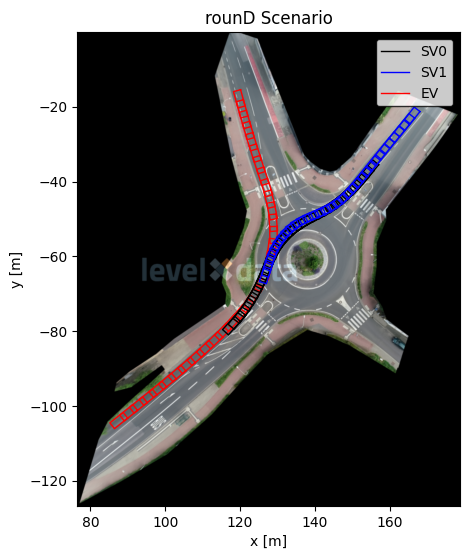

In [10]:
offset  = 76
x_low   = 0.5 + offset
x_up    = 102.85 + offset
y_low   = -126.7
y_up    = -0.06

def rota_rect(state, l, w):
    # Note: the first four states must be x, y, heading, velocity
    x       = state[0]
    y       = state[1]
    box     = [(x - l/2, y + w/2), (x + l/2, y + w/2), (x + l/2, y - w/2), (x - l/2, y - w/2)]
    heading = state[2]
    
    box_matrix = np.array(box) - np.repeat(np.array([[x, y]]), len(box), 0)
    theta = -heading
    rota_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

    new = box_matrix.dot(rota_matrix) + np.repeat(np.array([[x, y]]), len(box), 0)
    
    x = [new[0][0], new[1][0], new[2][0], new[3][0], new[0][0]]
    y = [new[0][1], new[1][1], new[2][1], new[3][1], new[0][1]]
    return x, y

plt.figure(figsize=(4.8, 6), tight_layout = True)
plt.xlim(x_low, x_up)
plt.ylim(y_low, y_up)

img = mpimg.imread('01_background.png')
plt.imshow(img, extent=[x_low, x_up, y_low, y_up]) 

for k in range(len(State_EV[0])):
    
    x_SV0, y_SV0 = rota_rect(State_SV0[:, k], l_veh_sv0, w_veh_sv0)
    x_SV1, y_SV1 = rota_rect(State_SV1[:, k], l_veh_sv1, w_veh_sv1)
    x_EV, y_EV   = rota_rect(State_EV[:, k], l_veh, w_veh)

    if k == 0: 
        plt.plot(x_SV0, y_SV0, c='k', linewidth=1, label='SV0')
        plt.plot(x_SV1, y_SV1, c='b', linewidth=1, label='SV1')
        plt.plot(x_EV, y_EV, c='r', linewidth=1, label='EV')
    else:  
        plt.plot(x_SV0, y_SV0, c='k', linewidth=1)
        plt.plot(x_SV1, y_SV1, c='b', linewidth=1)
        plt.plot(x_EV, y_EV, c='r', linewidth=1)
plt.title("rounD Scenario")
plt.legend(facecolor='white', edgecolor='black')
plt.xlabel("x [m]")
plt.ylabel("y [m]")